# Banana Hunter

---
Created by Jesper Højmark Esbensen, 2018-08-31.<br>
<br>

This note book will create and train an agent to collect yellow bananas in the Unity Machine Learning environment Banana. The solution is based on the general deep reenforcement learning agent supplied in the cource [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

<img src="banana-env.png",width=750>

The environment is a square where yellow and blue bananas are dropping out of the sky. The agent is giving directions to at wagon that moves around in the square and collects bananas. Yellow bananas are rewarded with 1 point and blue bananas with -1. The tast is to collect at least 13 points in averge over 100 episodes. An episode is 1000 steps in the environment.<br>


### 1. Installation instructions

The banana hunter is a python, pyTorch agent living in a Unity Environment. The agent is run from a jupyter notebook. Therefore you will need some setup before you can run the agent. The following installation instructions apply for Windows 10, but you will be able to installe the same environment on Mac, Linux and other operating systems following the supplied links.

You will need to install python 3.6 and a few packages. One popular way to install python is through Anaconda. A python/R environment. To install this follow the instructions on: https://www.anaconda.com/distribution/.

Create an python environment using the "Create" button and select the python 3.6 version. Start a terminal for the environment and install jupyter.

Install jupyter in the environment. 

    python -m pip install --upgrade pip
    python -m pip install jupyter
   
or reference jupyters home page if you have problems: http://jupyter.org/install

The agent is bulid using Facebook's pyTorch. To install run the followin commands.

    conda install pytorch -c pytorch 
    pip3 install torchvision
    
or reference pyTorch's home page if you have problems: https://pytorch.org/

The environment is build on Unitys ML-agents modul. To run these you will need TensorFlow:

    pip install tensorflow==1.7.1

or reference TensorFlow's home page if you have problems: https://www.tensorflow.org/

Then install the ML-agenst from Unity.
Clone the repository: 

    git clone https://github.com/Unity-Technologies/ml-agents.git

find and change to the directory: ml-agents/python and install the ml-agenst with:

    pip install .

or reference this page if you have problems: https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation-Windows.md


To download this repository and run the banana hunter agent on your machine clone this github repository with the following command:

    git clone https://github.com/JesperEsbensen/drlnd-navigation-project.git

when cloned unpack the Banana_Windows_x86_64 in the same location so you get a subfolder: Banana_Windows_x86_64. If you unpack the environment in a different location you will need to change the path to the environment in the notebook accordingly.



### 2. Import the needed modules into the notebook environment


In [1]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

from unityagents import UnityEnvironment


### 3. Start the Unity Banana Environment

Test that the environment can be found by the script. The path must point to the pre-created Banana.exe file.

In [2]:
# Test if the environment is fould. 
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. The hardware

PyTorch can utilice the GPU of you machine if available. Here we find what device to use. It is refereced later to place the data on the CPU or GPU dependent on availablity.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('PyTorch will use the ', device)

PyTorch will use the  cuda:0


### 5. The neural network

The neural network is build with pyTorch's api and defined in the classes defined here: BananaNetworkFull, BananaNetworkFullRelu and .<br>
The banana network can be initialized with at number of parameters to create different network architechturs. The parameteres are the number of states, the actions to estimate, a list of number of nodes in hidden layers. The "layer set" created is different from the three classes:<br>
<br>
The **BananaNetWorkFull** creates fully connected layers from state input to action output. This is not a neural network from a certan viewpoint, but simply a liniar combination of the input to the output.<br>
<br>
The **BananaNetworkFullRelu** creats a fully connected layer plus a Relu activation function for each "layer set". This is a neural network.<br>
<br>
The **BananaNetworkFullReluDropout** creats a fully connected layer followed by a relu activation funtion and a dropout layer.<br>
<br>
For the unity banana environment the input will be the number of stats equal to 37 and the output layer are the estimated values of the 4 actions that the wagon can take.


In [4]:
# Define a neural network to learn actions for the banana collector.
  
class BananaNetworkFull(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers, seed=0, drop_p=0.5):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_layers (list of ints): Each number in the list is the number of nodes in that layer.
            seed (int): Random seed
            drop_p (float): Dropout rate for the drop out layer. NOT used in this class but needed for 
                            consistency with the over agen classes.
        """
        super(BananaNetworkFull, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        hidden_state = state
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            hidden_state = linear(hidden_state)
        
        action_value = self.output(hidden_state)
        return action_value

    
class BananaNetworkFullRelu(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers, seed=0, drop_p=0.5):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_layers (list of ints): Each number in the list is the number of nodes in that layer.
            seed (int): Random seed
            drop_p (float): Dropout rate for the drop out layer. NOT used in this class but needed for 
                            consistency with the over agen classes.
        """
        super(BananaNetworkFullRelu, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        hidden_state = state
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            hidden_state = F.relu(linear(hidden_state))
        
        action_value = self.output(hidden_state)
        return action_value
    
class BananaNetworkFullReluDropout(nn.Module):

    def __init__(self, state_size, action_size, hidden_layers, seed=0, drop_p=0.5):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            hidden_layers (list of ints): Each number in the list is the number of nodes in that layer.
            seed (int): Random seed
            drop_p (float): Dropout rate for the drop out layer.
        """
        super(BananaNetworkFullReluDropout, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], action_size)
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        hidden_state = state
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            hidden_state = F.relu(linear(hidden_state))
            hidden_state = self.dropout(hidden_state)
        
        action_value = self.output(hidden_state)
        return action_value
    
    
# Test the most complex of the networks.
model = BananaNetworkFullReluDropout(37, 4, [64, 32])
model


BananaNetworkFullReluDropout(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=37, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.5)
)

### 6. The agent

The agent is the "brain" of the wagon driving around in the Banana environment. The agent can take 4 actions: forward, backward, left and rigth. The agnet is implemented using Q-learning where the Q-table is replaced by a neural network. This is called Deep Q-learning. The neural network takes the state as input and predicts the best action to take as action with the maximum predicted value. To stabilize learining experience replay and double Q network is implemented.<br>
<br>
#### Q-learning

Q-learning is in its simple and discrete form a table lookup that goes from the state you are in combined with the action you can take in that state to a value of the new state you will be going to taking that action. The action to take is the one with the highest value.<br>
In deep Q-learning this table is replaced by a neural network that approximates the values found in the Q-table. This works bette in large state-spaces and in continuous space. The table is recreated in a network where thie input layers corresponds the state and the output layer values of taking the given aktions. One ouput pr action. The best action to take is the one with the maximum value (exploitation of known knowledge). In order to search the state space better, than taking the best action always the Q-learning algorithme is randomized with an epsilon-greedy pick of the next action (exploration).<br> Implementation of deep Q-learning and epsilon greedy pick of actions are mainly found in the function act and learn.<br>
<br>
For more detailed information read the Deepmind paper: **Human-level control through deep reinforcement learning.**<br> https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf<br>

#### Experience Replay
While the agent is taking "random" actions to explore the state-space it will go through at certain path from state to state. This series of state and actions is strongly correlated and if the agent is trained with this experience as it moves around the q-values will be updated in a biased way that can end up in a local unwanted minimum. The avoid this the moves and rewards are collected and stored in a buffer. No direct learing is applied. At a given interval a batche of samples are taken from the buffer and the network trained with them. This breaks the correlation and it enables more leaning from the same experience and smoothens the learing of the network. Above paper also contains details on this methodology. <br>
Implementation of experience replay is found in the step function and the ReplayBuffer. Here we make a learning step with 64 samples every 4 steps. So there is an increased learning by 64/4 = 16 from introducing the experience replay buffer.<br>
<br>
For more detailed information methods section of the Deepmind paper: **Human-level control through deep reinforcement learning.**<br> https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf<br>

#### Fixed Q-targets and Double Q-learning
Using the same network for both selecting and evaluating actions, can result in fluctuating or exploding weights especially in the begining of the learning process where the weights are initialized randomly. To prevent this the agent is implemented with a primary network called the qnetwork_local and a second Q-network called the qnetwork_target.<br>
The primary network called qnetwork_local is used in the act function to find the most valuable action to take. The result is stored in the replay buffer for later learing together with the the result of taking the action in the environment.<br>
At given interval of steps (update_every) the replay buffer is sampled and the batch used to train the qnetwork_local in the learn function. Here the qnetwork_target is used to calculate predicted q-values from the next state and the reward. The resulting q-values are compared to the direct evaluation of the state by the qnetwork_local and from the difference the qnetwork_local is trained.<br>
Finaly a part of the new knowlegde in the qnetwork_local is transfered to the qnetwork_target and used in the next learning phase.

In [5]:
class Agent(  ):
    """Interacts with and learns from the environment."""

    def __init__(self, NetworkType, state_size, action_size, hidden_layers, seed, drop_out=0.25, 
                 gamma = 0.99, tau = 1e-3, lr = 5e-4):
        
        """Initialize an Agent object.
        
        Params
        ======
            NetworkType: Network class to be used for estimation of actions values.
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            hidden_layers (list of int): Number of nodes in the hidden layers.
            seed (int): random seed
            drop_out: Drop out probability.
            gamma: discount factor for futur rewards.
            tau: Update rate for Double Q-learning.
            lr: Learn rate.
        """
        
        self.buffer_size = int(1e5)  # replay buffer size
        self.batch_size = 64         # minibatch size
        self.gamma = gamma           # discount factor
        self.tau = tau               # for soft update of target parameters
        self.lr = lr                 # learning rate 
        self.update_every = 4        # how often to update the network
        
        self.state_size = state_size
        self.action_size = action_size
        self.hidden_layers = hidden_layers
        self.seed = random.seed(seed)

        # Create two Q-Network's for implementation of Double Q-learning.
        self.qnetwork_local = NetworkType(state_size, action_size, self.hidden_layers, seed, drop_out).to(device)
        self.qnetwork_target = NetworkType(state_size, action_size, self.hidden_layers, seed, drop_out).to(device)
        
        # The agent uses the Adam optimizer.
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size, seed)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0  
    
    def step(self, state, action, reward, next_state, done):
        """Updates the agent with the action taken and the result of taking the action.
        
        Params
        ======
            state (array_like): current state
            action (int): epsilon, for epsilon-greedy action selection
            reward :
            next_state (array_like): 
            done:
        """
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                # The batch size samples and learn from them.
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # Turn off training mode.
        self.qnetwork_local.eval()
        with torch.no_grad():
            # Find best action to take
            action_values = self.qnetwork_local(state)
            
        # Turn on training mode.
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        # Note: The self.qnetwork_target(next_states) calls the __call__ function on the modul object
        # which calls the forward function. So we get a prediction.
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    
    # Getters
    def getInputSize(self):
        return self.state_size
    
    def getOutputSize (self):
        return self.action_size
    
    def getHiddenLayers (self):
        return self.hidden_layers
    
    

### 7. The Replay Buffer

The replay buffer is a storage for earlier experience. It is implemented as a deque of buffer_size length. 
The class supports adding a set of state, action, reward, next_state and done values and a function for 
sampling a batch of experiences from the deque.


In [6]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 8. The training loop

The training loop creates an episode by performing max_t steps in the environment. In each step the agent is asked for the best action to take (atc). The action is handed over to the environment to get at response and the result is stored in the replay buffer. At regular intervals the storage function is added a learning step to train the network.

In [7]:
def dqn( modelname, agent, best_score, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.997 ):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    # The default "brain" from the Unity environment is used.
    brain_name = env.brain_names[0]
    
    scores = []                        # list containing scores from each episode
    first_solved = None
    highest_score = 0
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        
        # Setup for a new episode.
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        # Step through episode until done or max steps have been reached.
        score = 0
        for t in range(max_t):
            # Get next action.
            action = agent.act(state, eps)
            #print ('act: ', action, 'brain_name: ', brain_name)
            
            # Determin next state.
            env_info = env.step(int(action))[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            # Store or learn from step.
            agent.step(state, action, reward, next_state, done)
            
            # Prepare for next action.
            state = next_state
            score += reward   
            if done:
                break 
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # Print score.
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
            sc = np.mean(scores_window)
            highest_score = max (highest_score, sc)
            
            # Save models when targeet has been exceeded.
            if sc >= 13:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
                
                if not first_solved:
                    first_solved = i_episode
            
            if sc > best_score:
                best_score = sc
                print ('Achieved best score:', best_score )
                checkpoint = {
                    'title': modelname,
                    'best_score': best_score,
                    'first_solved': first_solved,
                    'episode': i_episode,
                    'input_size': agent.getInputSize(),
                    'output_size': agent.getOutputSize(),
                    'hidden_layers': agent.getHiddenLayers(),
                    'state_dict': model.state_dict()}
                torch.save(checkpoint, 'bestcheckpoint.pth')
            
    return scores, best_score, highest_score, first_solved



### 9. Plot results

The training loop collects a list of scores that the agent has achieved. This score is plotted with the pyplot class in the matplotlib.

In [8]:
import matplotlib.pyplot as plt

# Plot scores
def plotScors (scores, best_score, first_solved):
    # Plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    
    if first_solved:
        print ('The environment was first solved at episode :', first_solved, ' the best score was :', best_score )
    else:
        print ('The environment was never solved')
    
# Initialize best score to accepted level.
best_score = 13

### 10. Solving the environment

The following section is a list of expriments with different configurations of networks and hyperparameters. The architecture and hyperparametes are explained for each experiment. <br>
For each experiment the resulting score is plotted as a function of episodes and across all experiments the best model and its parameters are stored in the bestcheckpoint.pth file.

#### 10.1 Fully connected layer - no Relu
The first neural network consist of 3 fully connected layer. The layers go from the input of 37 states to 32 hidden nodes, 16 hidden nodes and an output of 4 actions. There are no activation functions added so the end result will be a liniar combination of the input. Not really a neural network - but good as a benchmark for addeing a relu in the next section.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.30
Episode 200	Average Score: 2.57
Episode 300	Average Score: 4.32
Episode 400	Average Score: 5.08
Episode 500	Average Score: 6.33
Episode 600	Average Score: 5.98
Episode 700	Average Score: 6.81
Episode 800	Average Score: 7.40
Episode 900	Average Score: 7.16
Episode 1000	Average Score: 9.05
Episode 1100	Average Score: 8.54
Episode 1200	Average Score: 8.85
Episode 1300	Average Score: 8.69
Episode 1400	Average Score: 9.72
Episode 1500	Average Score: 10.66
Episode 1600	Average Score: 11.23
Episode 1700	Average Score: 11.70
Episode 1800	Average Score: 11.17
Episode 1900	Average Score: 11.13
Episode 2000	Average Score: 11.23


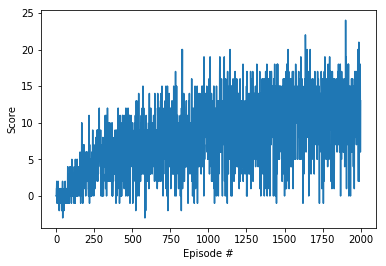

The environment was never solved


In [9]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFull, state_size=37, action_size=4, hidden_layers=[32, 16], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.1 BananaNetworkFull 32/16', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)


#### 10.2 Fully connected layer with Relu
The first neural network consist of 3 fully connected layer. The layers go from the input of 37 states to 32 hidden nodes, 
16 hidden nodes and an output of 4 actions. Every layer except the last is followed by a relu activation function.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: -0.09
Episode 200	Average Score: 2.414
Episode 300	Average Score: 5.35
Episode 400	Average Score: 6.73
Episode 500	Average Score: 9.53
Episode 600	Average Score: 12.12
Episode 700	Average Score: 12.53
Episode 800	Average Score: 12.89
Episode 900	Average Score: 14.09

Environment solved in 800 episodes!	Average Score: 14.09
Achieved best score: 14.09
Episode 1000	Average Score: 14.72

Environment solved in 900 episodes!	Average Score: 14.72
Achieved best score: 14.72
Episode 1100	Average Score: 14.35

Environment solved in 1000 episodes!	Average Score: 14.35
Episode 1200	Average Score: 14.73

Environment solved in 1100 episodes!	Average Score: 14.73
Achieved best score: 14.73
Episode 1300	Average Score: 15.12

Environment solved in 1200 episodes!	Average Score: 15.12
Achieved best score: 15.12
Episode 1400	Average Score: 15.88

Environment solved in 1300 episodes!	Average Score: 15.88
Achieved best score: 15.88
Episode 1500	Average Score: 15.52

Environment so

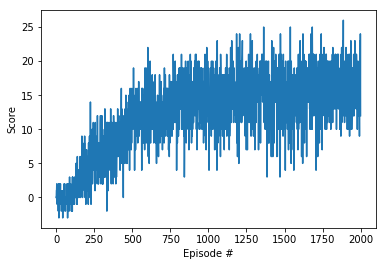

The environment was first solved at episode : 900  the best score was : 16.32


In [10]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[32, 16], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.2 BananaNetworkFullRelu  32/16', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.3 Fully connected layer with Relu and dropout.
The first neural network consist of 3 fully connected layer. The layers go from the input of 37 states to 32 hidden nodes, 
16 hidden nodes and an output of 4 actions. Every layer except the last is followed by a relu activation function and a dropout layer with at dropout rate of 0.25.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.45
Episode 200	Average Score: 1.95
Episode 300	Average Score: 4.84
Episode 400	Average Score: 8.25
Episode 500	Average Score: 8.33
Episode 600	Average Score: 8.01
Episode 700	Average Score: 10.23
Episode 800	Average Score: 10.63
Episode 900	Average Score: 10.29
Episode 1000	Average Score: 11.77
Episode 1100	Average Score: 11.73
Episode 1200	Average Score: 11.65
Episode 1300	Average Score: 11.79
Episode 1400	Average Score: 11.72
Episode 1500	Average Score: 12.23
Episode 1600	Average Score: 10.71
Episode 1700	Average Score: 12.38
Episode 1800	Average Score: 11.99
Episode 1900	Average Score: 11.84
Episode 2000	Average Score: 12.16


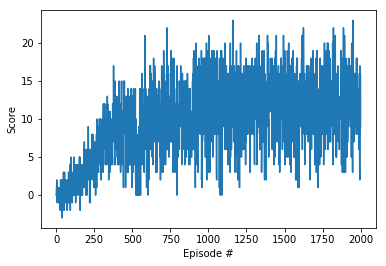

The environment was never solved


In [11]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullReluDropout, state_size=37, action_size=4, hidden_layers=[32, 16], drop_out=0.25, seed=0)
scores, best_score, highest_score, first_solved = dqn('9.3 BananaNetworkFullReluDropout  32/16', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.4 Fully connected layer with Relu and double nodes.

The fully connected with relu is the best performing of the above layers. So here I try out this kind of network in different sizes. This network doubles the number of hidden nodes. So the network consists of of 3 fully connected layer. The layers go from the input of 37 states to 64 hidden nodes, 32 hidden nodes and an output of 4 actions. Every layer except the last is followed by a relu activation.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.46
Episode 200	Average Score: 2.62
Episode 300	Average Score: 4.99
Episode 400	Average Score: 6.82
Episode 500	Average Score: 9.23
Episode 600	Average Score: 10.96
Episode 700	Average Score: 12.51
Episode 800	Average Score: 13.15

Environment solved in 700 episodes!	Average Score: 13.15
Episode 900	Average Score: 13.03

Environment solved in 800 episodes!	Average Score: 13.03
Episode 1000	Average Score: 13.69

Environment solved in 900 episodes!	Average Score: 13.69
Episode 1100	Average Score: 15.54

Environment solved in 1000 episodes!	Average Score: 15.54
Episode 1200	Average Score: 15.64

Environment solved in 1100 episodes!	Average Score: 15.64
Episode 1300	Average Score: 16.41

Environment solved in 1200 episodes!	Average Score: 16.41
Achieved best score: 16.41
Episode 1400	Average Score: 16.30

Environment solved in 1300 episodes!	Average Score: 16.30
Episode 1500	Average Score: 15.98

Environment solved in 1400 episodes!	Average Score: 15.98
Episode 

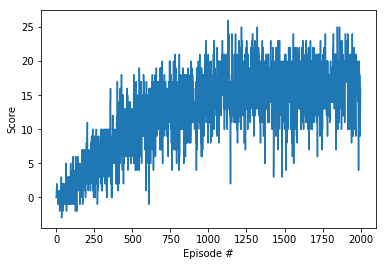

The environment was first solved at episode : 800  the best score was : 16.85


In [12]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.4 BananaNetworkFullRelu double nodes 64/32', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.5 Fully connected layer with Relu with an extra layer.

This network doubles the number of hidden nodes. So the network consists of of 3 fully connected layer. The layers go from the input of 37 states to 64 hidden nodes, 32 hidden nodes, 16 hidden nodes and an output of 4 actions. Every layer except the last is followed by a relu activation.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.41
Episode 200	Average Score: 2.90
Episode 300	Average Score: 5.64
Episode 400	Average Score: 7.57
Episode 500	Average Score: 9.76
Episode 600	Average Score: 11.01
Episode 700	Average Score: 12.61
Episode 800	Average Score: 13.67

Environment solved in 700 episodes!	Average Score: 13.67
Episode 900	Average Score: 14.42

Environment solved in 800 episodes!	Average Score: 14.42
Episode 1000	Average Score: 13.93

Environment solved in 900 episodes!	Average Score: 13.93
Episode 1100	Average Score: 15.94

Environment solved in 1000 episodes!	Average Score: 15.94
Episode 1200	Average Score: 15.01

Environment solved in 1100 episodes!	Average Score: 15.01
Episode 1300	Average Score: 15.92

Environment solved in 1200 episodes!	Average Score: 15.92
Episode 1400	Average Score: 15.46

Environment solved in 1300 episodes!	Average Score: 15.46
Episode 1500	Average Score: 15.60

Environment solved in 1400 episodes!	Average Score: 15.60
Episode 1600	Average Score: 14.97



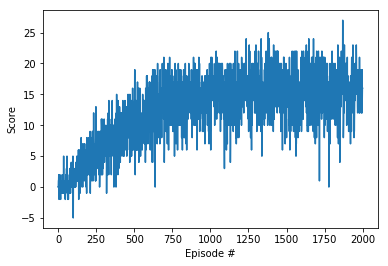

The environment was first solved at episode : 800  the best score was : 15.94


In [13]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32, 16], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.5 BananaNetworkFullRelu extra layer 64/32/16', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.6 Fully connected layer with Relu and a small hidden layer.

This network has only one hidden layer of 16 nodes. The layers go from the input of 37 states to 16 hidden nodes and an output of 4 actions. Every layer except the last is followed by a relu activation.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.45
Episode 200	Average Score: 3.38
Episode 300	Average Score: 5.26
Episode 400	Average Score: 7.36
Episode 500	Average Score: 7.96
Episode 600	Average Score: 8.37
Episode 700	Average Score: 8.73
Episode 800	Average Score: 8.52
Episode 900	Average Score: 10.42
Episode 1000	Average Score: 11.28
Episode 1100	Average Score: 13.12

Environment solved in 1000 episodes!	Average Score: 13.12
Episode 1200	Average Score: 13.76

Environment solved in 1100 episodes!	Average Score: 13.76
Episode 1300	Average Score: 14.29

Environment solved in 1200 episodes!	Average Score: 14.29
Episode 1400	Average Score: 14.35

Environment solved in 1300 episodes!	Average Score: 14.35
Episode 1500	Average Score: 13.36

Environment solved in 1400 episodes!	Average Score: 13.36
Episode 1600	Average Score: 15.32

Environment solved in 1500 episodes!	Average Score: 15.32
Episode 1700	Average Score: 15.13

Environment solved in 1600 episodes!	Average Score: 15.13
Episode 1800	Average Score

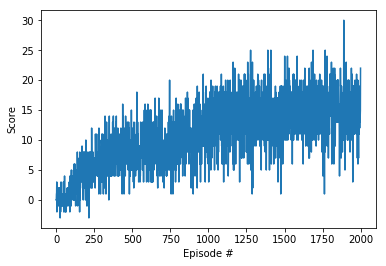

The environment was first solved at episode : 1100  the best score was : 15.42


In [14]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[16], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.6 BananaNetworkFullRelu one hidden layer 16', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.7 Fully connected layer with Relu extra exploration.

This network is identical to 10.4 with double nodes. But the hyper parameter for epsilon decay is raised to 0.998 
to add additional exploration for the state space.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.35
Episode 200	Average Score: 1.77
Episode 300	Average Score: 3.88
Episode 400	Average Score: 5.24
Episode 500	Average Score: 6.76
Episode 600	Average Score: 8.47
Episode 700	Average Score: 9.90
Episode 800	Average Score: 11.43
Episode 900	Average Score: 12.67
Episode 1000	Average Score: 12.73
Episode 1100	Average Score: 13.42

Environment solved in 1000 episodes!	Average Score: 13.42
Episode 1200	Average Score: 13.15

Environment solved in 1100 episodes!	Average Score: 13.15
Episode 1300	Average Score: 13.19

Environment solved in 1200 episodes!	Average Score: 13.19
Episode 1400	Average Score: 13.70

Environment solved in 1300 episodes!	Average Score: 13.70
Episode 1500	Average Score: 14.93

Environment solved in 1400 episodes!	Average Score: 14.93
Episode 1600	Average Score: 14.90

Environment solved in 1500 episodes!	Average Score: 14.90
Episode 1700	Average Score: 15.47

Environment solved in 1600 episodes!	Average Score: 15.47
Episode 1800	Average Scor

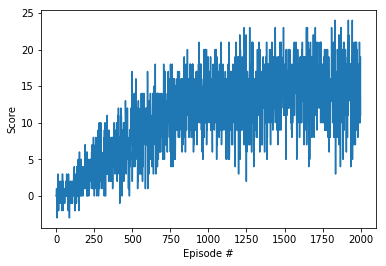

The environment was first solved at episode : 1100  the best score was : 15.47


In [15]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0)
scores, best_score, highest_score, first_solved = dqn('9.7 BananaNetworkFullRelu 64/32 - more exploration', agent, best_score, eps_decay=0.998)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.8 Fully connected layer with higher learn rate.

This network is identical to 10.4 with double nodes. But the hyper parameter for learn rate is raised to lr = 5e-3 (a factor 10) to increase learn rate.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.493
Episode 300	Average Score: 2.19
Episode 400	Average Score: 4.68
Episode 500	Average Score: 6.66
Episode 600	Average Score: 8.40
Episode 700	Average Score: 9.93
Episode 800	Average Score: 9.800
Episode 900	Average Score: 10.84
Episode 1000	Average Score: 11.38
Episode 1100	Average Score: 11.41
Episode 1200	Average Score: 11.03
Episode 1300	Average Score: 10.80
Episode 1400	Average Score: 11.27
Episode 1500	Average Score: 12.10
Episode 1600	Average Score: 11.60
Episode 1700	Average Score: 12.33
Episode 1800	Average Score: 11.13
Episode 1900	Average Score: 12.48
Episode 2000	Average Score: 12.16


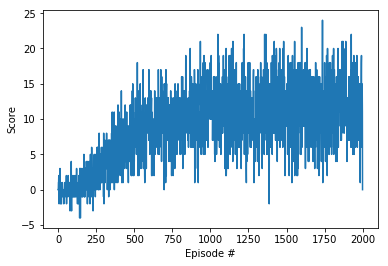

The environment was never solved


In [16]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0, lr = 5e-3)
scores, best_score, highest_score, first_solved = dqn('9.8 BananaNetworkFullRelu 64/32 - faster learning', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.9 Fully connected layer with higher transferrate between networks.

This network is identical to 10.4 with double nodes. But the hyper parameter for updating the parameters from the local network to the target network is increased by a factor of 10 (tau = 1e-3).

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.46
Episode 200	Average Score: 2.62
Episode 300	Average Score: 4.99
Episode 400	Average Score: 6.82
Episode 500	Average Score: 9.23
Episode 600	Average Score: 10.96
Episode 700	Average Score: 12.51
Episode 800	Average Score: 13.15

Environment solved in 700 episodes!	Average Score: 13.15
Episode 900	Average Score: 13.03

Environment solved in 800 episodes!	Average Score: 13.03
Episode 1000	Average Score: 13.69

Environment solved in 900 episodes!	Average Score: 13.69
Episode 1100	Average Score: 15.54

Environment solved in 1000 episodes!	Average Score: 15.54
Episode 1200	Average Score: 15.64

Environment solved in 1100 episodes!	Average Score: 15.64
Episode 1300	Average Score: 16.41

Environment solved in 1200 episodes!	Average Score: 16.41
Episode 1400	Average Score: 16.30

Environment solved in 1300 episodes!	Average Score: 16.30
Episode 1500	Average Score: 15.98

Environment solved in 1400 episodes!	Average Score: 15.98
Episode 1600	Average Score: 15.84



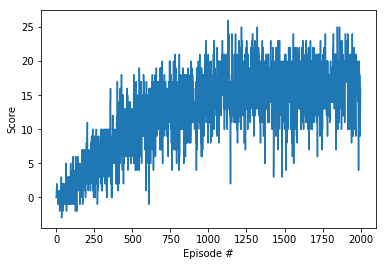

The environment was first solved at episode : 800  the best score was : 16.85


In [17]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0, tau = 1e-3)
scores, best_score, highest_score, first_solved = dqn('9.9 BananaNetworkFullRelu 64/32 - faster transition', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.10 Fully connected layer with no discount rate.

This network is identical to 10.4 with double nodes, but the hyper parameter for discounting future state values is increased to 1 (default value is: gamma = 0.99).

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.21
Episode 200	Average Score: 2.28
Episode 300	Average Score: 4.49
Episode 400	Average Score: 6.63
Episode 500	Average Score: 8.87
Episode 600	Average Score: 10.58
Episode 700	Average Score: 12.75
Episode 800	Average Score: 13.93

Environment solved in 700 episodes!	Average Score: 13.93
Episode 900	Average Score: 13.80

Environment solved in 800 episodes!	Average Score: 13.80
Episode 1000	Average Score: 13.80

Environment solved in 900 episodes!	Average Score: 13.80
Episode 1100	Average Score: 13.65

Environment solved in 1000 episodes!	Average Score: 13.65
Episode 1200	Average Score: 15.25

Environment solved in 1100 episodes!	Average Score: 15.25
Episode 1300	Average Score: 14.31

Environment solved in 1200 episodes!	Average Score: 14.31
Episode 1400	Average Score: 14.91

Environment solved in 1300 episodes!	Average Score: 14.91
Episode 1500	Average Score: 15.13

Environment solved in 1400 episodes!	Average Score: 15.13
Episode 1600	Average Score: 15.74



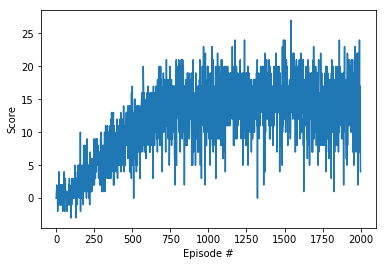

The environment was first solved at episode : 800  the best score was : 15.74


In [18]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0, gamma = 1.0)
scores, best_score, highest_score, first_solved = dqn('9.10 BananaNetworkFullRelu 64/32 - no discounting', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

#### 10.11 Fully connected layer with higher discounting.

This network is identical to 10.4 with double nodes, but the hyper parameter for discounting future state values is decreased to 0.95 (default value is: gamma = 0.99).

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.13
Episode 200	Average Score: 1.96
Episode 300	Average Score: 6.11
Episode 400	Average Score: 8.00
Episode 500	Average Score: 9.89
Episode 600	Average Score: 11.50
Episode 700	Average Score: 12.33
Episode 800	Average Score: 12.94
Episode 900	Average Score: 13.86

Environment solved in 800 episodes!	Average Score: 13.86
Episode 1000	Average Score: 14.95

Environment solved in 900 episodes!	Average Score: 14.95
Episode 1100	Average Score: 14.86

Environment solved in 1000 episodes!	Average Score: 14.86
Episode 1200	Average Score: 15.91

Environment solved in 1100 episodes!	Average Score: 15.91
Episode 1300	Average Score: 15.67

Environment solved in 1200 episodes!	Average Score: 15.67
Episode 1400	Average Score: 15.79

Environment solved in 1300 episodes!	Average Score: 15.79
Episode 1500	Average Score: 16.32

Environment solved in 1400 episodes!	Average Score: 16.32
Episode 1600	Average Score: 15.68

Environment solved in 1500 episodes!	Average Score: 15.68


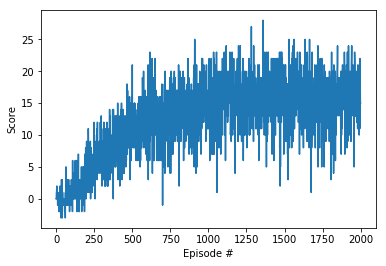

The environment was first solved at episode : 900  the best score was : 16.32


In [19]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")
agent = Agent(BananaNetworkFullRelu, state_size=37, action_size=4, hidden_layers=[64, 32], seed=0, gamma = 0.95)
scores, best_score, highest_score, first_solved = dqn('9.11 BananaNetworkFullRelu 64/32 - higher discounting', agent, best_score)
env.close()

plotScors (scores, highest_score, first_solved)

### 11. Best model/hyper parameter combination.

Print name and result from the best model.

In [20]:
checkpoint = torch.load('bestcheckpoint.pth')
print ('The model with the best score was:',checkpoint['title'], ' it received a score of ', 
       checkpoint['best_score'], ' at episode', checkpoint['episode'], 
       ' the model solved the environment first time at episode', checkpoint['first_solved'])


The model with the best score was: 9.4 BananaNetworkFullRelu double nodes 64/32  it received a score of  16.85  at episode 1900  the model solved the environment first time at episode 800


#### Close the environment
If for some reason the cells above do not finish properly this celle is used to manually close the Unity environment.

In [21]:
#env.close()

### 12. Conclusion

The best working model was the one in section 10.4. The architecure is:

    input layer - 37 states
    |
    fully connected hidden layer - 64 nodes followed by a ReLu
    |
    fully connected hidden layer - 32 nodes followed by a ReLu
    |
    fully connected ouput layer with 4 outputs.

it solved the environment in 800 episodes and reached a maximum score of 16.85.<br>
Adding dropouts, no Relu's, and high learn rate all resulted in an agent that diden't solve the environment.



### 13. Future improvements

The model can propably be improved by further adjustment of the hyper parameters. But to get substantial improvement some of the resent methods could be implemented.

**Prioritized Experience Replay**<br>
The experience replay implemented in this notebook is sampling equally from all the stored experiences. But some experiences are more usefull that others. Therefor the algorithme could be improved by selecting the more important and learn more from them. One criteria to select differently could be the TD error that is calculated as part of the calucation of Q-values. Sampling based on this values could improve perfomance. <br>
This idea is described in the paper:  Prioritized Experience Replay, 2016, https://arxiv.org/abs/1511.05952

**Dueling DQN**
The pressent implementation calculates the action value directly from the state. Using dueling networks a network calculating the value of the new state is added and the sum of state value and action value is used for finding the next best action. This moves the focus from the action being the most important towards the value of the state. This has shown to be an improvement in the paper: Dueling Network Architectures for Deep Reinforcement Learning, 2016, https://arxiv.org/abs/1511.06581.

**A3C**
With the A3C (Asynchronous Advantage Actor Critic) algorithme multiple agenst are training at the same time on the same global weights. This can replace the experience replay buffer as the correlation is removed by the different agents. This algoritme was introduced in the paper: Asynchronous Methods for Deep Reinforcement Learning, 2016, https://arxiv.org/abs/1602.01783

**Noisy DQN**
In a noisy neural network the epsilon greedy exploration of the state space is replaced by adding noice to the weights and biases of the network. The method is described in the paper: Noicy Networks For Exploration, 2018, https://arxiv.org/abs/1706.10295

